In [1]:
from nlp import Dataset
import pandas as pd
import re
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast
from torch.nn import Softmax
from torch import tensor, where
from torch.utils.data import DataLoader

from random import seed

seed(42)


In [2]:
# read our tweet sample
tweets = pd.read_csv('../data/cleaned_tweets.csv', encoding='ISO-8859-1')

# convert the date to a datetime format
tweets['date'] = pd.to_datetime(tweets['TweetAt']).astype('datetime64[ms]')

# set our index as our datetime column and delete the date columns
tweets.index = tweets['date']
del tweets['date']

# Sort our tweets
tweets.sort_index(inplace=True)

In [3]:
# create an index that we can reference later
tweets['index'] = range(tweets.shape[0])

In [4]:
# load up a pre-trained bert

BERT_MODEL = 'distilbert-base-uncased'

bert_tokenizer = DistilBertTokenizerFast.from_pretrained(BERT_MODEL)


In [5]:
# Grab the same training data as the model_drift notebook
tweets = tweets[:'2020-03']

In [6]:
# Create a Dataset
tweet_dataset = Dataset.from_pandas(tweets.reset_index()[['text', 'label', 'index']])

# Dataset has a built in train test split method
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# We will pad our dataset so that our input matrices are the same length
def preprocess(data):
    return bert_tokenizer(data['text'], padding=True, truncation=True, max_length=128)

# map the preprocess function over the dataset
train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label', 'index'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label', 'index'])

Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction


  0%|          | 0/1 [00:00<?, ?it/s]

Ignored unknown kwarg option direction


In [8]:
# Define a sequence classification model
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_clas

![title](../images/aum.png)


In [9]:
# https://github.com/asappresearch/aum
from aum import AUMCalculator

# Set a directory to save our results
save_dir = './clean'
# Setting compressed to False gives us information over several epochs
aum_calculator = AUMCalculator(save_dir, compressed=False)

In [10]:
# We are going to define the training process without the training arguments

In [11]:
from transformers import AdamW
from transformers import get_scheduler

# Define our optimizer. Nothing special here
optimizer = AdamW(sequence_classification_model.parameters(), lr=5e-5)
train_loader = DataLoader(train_set, batch_size=64, shuffle=False)

# Train for 10 epochs to get as much data as possible
num_epochs = 10
# Set the number of training steps
num_training_steps = num_epochs * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

/opt/homebrew/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

# Set our model to training mode as opposed to .eval()
sequence_classification_model.train()

for epoch in range(num_epochs):
    # For every epoch, iterate over batches of data
    for batch in train_loader:
        # pass the data into the model without the index column
        _batch = {k: v for k, v in batch.items() if k not in ('index',)}
        _batch['labels'] = _batch['label']  # not very effecient way to change the label name for the siamese network
        del _batch['label']
        outputs = sequence_classification_model(**_batch)
        
        # PyTorch training code
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        
        # Update records in our AUM Calculator
        records = aum_calculator.update(outputs.logits, batch['label'], batch['index'].tolist())
        
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/270 [00:00<?, ?it/s]

In [14]:
# Create the final csvs for analysis
aum_calculator.finalize()

In [15]:
# Read the compressed values
# Lower values are meant to signify potentially mislabeled data
# Higher values are meant to signify potentially properly labelled data
aum_values = pd.read_csv('./clean/aum_values.csv')

# one value per datapoint
print(aum_values.shape)

# Most likely to be labelled correctly
aum_values.head()

(1725, 2)


,sample_id,aum
0,361,4.209358
1,1113,4.088204
2,256,4.083540
3,1868,4.080309
4,1630,4.061262


In [16]:
# Most likely to be labelled incorrectly
aum_values.tail()

,sample_id,aum
1720,65,-2.612194
1721,180,-2.618396
1722,1430,-2.796174
1723,1678,-3.272786
1724,538,-4.253930


In [17]:
# Read the uncompressed values over all epochs. 10 values for each datapoint
all_aum_records = pd.read_csv('./clean/full_aum_records.csv')
print(all_aum_records.shape)
all_aum_records.head()

(17250, 8)


,sample_id,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum
0,1,1,2,0.198237,0,-0.138813,0.337051,0.337051
1,1,2,2,0.557133,1,-0.130709,0.687842,0.512447
2,1,3,2,2.004453,1,-1.186220,3.190673,1.405189
3,1,4,2,2.073597,1,-1.556555,3.630152,1.961430
4,1,5,2,2.925448,1,-1.818266,4.743714,2.517886


In [18]:
# the highest AUM
highest_sample_aum = int(aum_values.iloc[0].sample_id)

print(highest_sample_aum)

all_aum_records[all_aum_records['sample_id'] == highest_sample_aum]

361


,sample_id,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum
2850,361,1,2,0.556913,1,-0.273760,0.830673,0.830673
2851,361,2,2,1.701820,1,-0.870721,2.572541,1.701607
2852,361,3,2,1.858733,1,-1.535856,3.394588,2.265934
2853,361,4,2,2.346128,1,-1.541910,3.888037,2.671460
2854,361,5,2,2.500566,1,-1.794343,4.294909,2.996150
2855,361,6,2,2.938168,1,-1.776797,4.714965,3.282619
2856,361,7,2,3.431428,1,-2.411874,5.843302,3.648431
2857,361,8,2,3.326487,1,-2.254889,5.581376,3.890049
2858,361,9,2,3.441489,1,-2.182501,5.623989,4.082709
2859,361,10,2,3.326401,1,-2.022795,5.349196,4.209358


<AxesSubplot:title={'center':'Sample 361'}>

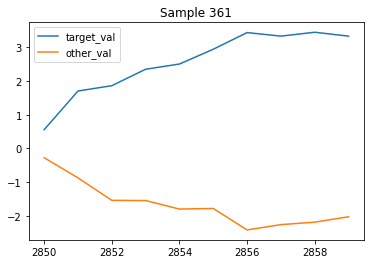

In [19]:
# Plotting the Logit difference between the intended label and the next highest label.
# The target logit is MUCH larger than the next logit which is ideal
all_aum_records[all_aum_records['sample_id'] == highest_sample_aum][['target_val', 'other_val']].plot(
    title=f'Sample {highest_sample_aum}'
)

In [20]:
high_tweet = tweets.iloc[highest_sample_aum]

print(high_tweet['text'])
print(high_tweet['Sentiment'])

Coronavirus career pivots: 'I now work in a supermarket' great story. Make yourself useful coronavirus COVID19 hope2020 url
Extremely Positive


In [21]:
# the lowest AUM
lowest_sample_aum = int(aum_values.iloc[-1].sample_id)

print(lowest_sample_aum)

all_aum_records[all_aum_records['sample_id'] == lowest_sample_aum]

538


,sample_id,num_measurements,target_logit,target_val,other_logit,other_val,margin,aum
4200,538,1,1,-0.622310,2,0.396324,-1.018633,-1.018633
4201,538,2,1,-1.193044,2,1.504937,-2.697981,-1.858307
4202,538,3,1,-1.715639,2,2.061665,-3.777304,-2.497973
4203,538,4,1,-1.317606,2,2.454161,-3.771767,-2.816421
4204,538,5,1,-1.985396,2,2.814141,-4.799537,-3.213044
4205,538,6,1,-2.141761,2,2.941527,-5.083287,-3.524752
4206,538,7,1,-1.965180,2,3.291921,-5.257101,-3.772230
4207,538,8,1,-2.194505,2,3.254621,-5.449125,-3.981842
4208,538,9,1,-2.392138,2,3.095144,-5.487282,-4.149113
4209,538,10,1,-2.181969,2,3.015314,-5.197283,-4.253930


<AxesSubplot:title={'center':'Sample 538'}>

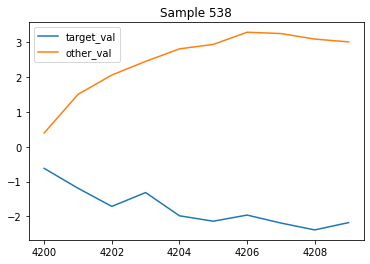

In [22]:
# Plotting the Logit difference between the intended label and the next highest label.
# The next logit is MUCH larger than the target logit which is not ideal
all_aum_records[all_aum_records['sample_id'] == lowest_sample_aum][['target_val', 'other_val']].plot(
    title=f'Sample {lowest_sample_aum}'
)


In [23]:
low_tweet = tweets.iloc[lowest_sample_aum]

print(low_tweet['text'])
print(low_tweet['Sentiment'])

very nice of you not to ask compensation from for causing the SARS virus caused by their overdirty food markets BUT HOW ABOUT this   Demand
Neutral


## Using cosine similarity to find confusing phrases

<img src='https://www.sbert.net/_images/SBERT_Siamese_Network1.png'>

In [24]:
# https://www.sbert.net/docs/usage/semantic_textual_similarity.html

from sentence_transformers import SentenceTransformer, util
# Use a pre-trained model specifically for symmetric semantic text similarity
model = SentenceTransformer('all-MiniLM-L6-v2')

In [25]:
# Embed all tweets into a vector space
embeddings = model.encode(tweets['text'].tolist(), convert_to_tensor=True)

Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg option direction
Ignored unknown kwarg opt

In [26]:
# Calculate cosine similarity for each pair and set a threshold (higher is more semantically similar)
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)

COSINE_THRESHOLD = 0.9

In [27]:
# Highlight pairs of tweets that are semantically similar but have different labels
index1, index2 = where(cosine_scores >= COSINE_THRESHOLD)
pairs_to_consider = list(zip(index1.tolist(), index2.tolist()))
for i1, i2 in pairs_to_consider[:len(pairs_to_consider)//2]:
    if i1 != i2:
        samples = tweets[tweets['index'].isin([i1, i2])]
        if samples['Sentiment'].nunique() > 1:
            print(i1, i2, samples[['OriginalTweet', 'Sentiment']].values)
            print('--------')

175 250 [['Covid-19 #heroes: Ã\x82Â\x91The #pub may be closed but that doesnÃ\x82Â\x92t mean we canÃ\x82Â\x92t help peopleÃ\x82Â\x92 https://t.co/RJCkmLDVt5 #coronavirus'
  'Positive']
 ['Covid-19 heroes: Ã\x82Â\x91The pub may be closed but that doesnÃ\x82Â\x92t mean we canÃ\x82Â\x92t help peopleÃ\x82Â\x92\r\r\nhttps://t.co/mpq8VYPrcT #coronavirus positive mindset'
  'Extremely Positive']]
--------
229 440 [["'A Perfect Storm': U.S. Facing Hunger Crisis as Demand for Food Banks Soars https://t.co/wpA6p2XLU7 @theguardian #coronavirus #COVID19 #foodinsecurity"
  'Negative']
 ["'A perfect storm': US facing #hunger #crisis as demand for #foodbanks soars | Environment | The Guardian #ados #pandemic #coronavirus  https://t.co/JboPvSFgLZ"
  'Positive']]
--------
250 175 [['Covid-19 #heroes: Ã\x82Â\x91The #pub may be closed but that doesnÃ\x82Â\x92t mean we canÃ\x82Â\x92t help peopleÃ\x82Â\x92 https://t.co/RJCkmLDVt5 #coronavirus'
  'Positive']
 ['Covid-19 heroes: Ã\x82Â\x91The pub may be clos

# Highlighting a particular pair 

```
1040 [['Need toilet paper Police officers handed out toilet paper rolls at a Sydney supermarket to try to calm panic buying shoppers during the epidemic'
  'Negative']
  
1543 ['Police officers handed out rolls of toilet paper at a Sydney supermarket on Thursday to try to calm shoppers down during the outbreak in Australia'
  'Positive']]
```

In [30]:
# AUM says they are both fairly fine
aum_values[aum_values['sample_id'].isin((1040, 1543))]

,sample_id,aum
1194,1543,2.670452
1291,1040,2.524233


In [32]:
aum_values['aum'].describe()  # AUM values are low but not crazy low

count    1725.000000
mean        2.821769
std         0.928710
min        -4.253930
25%         2.521283
50%         3.029245
75%         3.387813
max         4.209358
Name: aum, dtype: float64

In [36]:
URL_REGEX = re.compile('http(s)?:\/\/t.co\/\w+')
MENTION_REGEX = re.compile('@\w+')
def clean_tweet(tweet):
    # remove mentions, the pound sign, and replace urls with URL token
    tweet = re.sub(URL_REGEX, 'url', tweet)  # replace urls with url. Assumes that the mention of a url is significant
    tweet = re.sub(MENTION_REGEX, '', tweet)  # remove mentions entirely
    tweet = tweet.replace('#', '')  # remove pound signs
    
    return tweet.strip()

In [40]:
# Our model is VERY confident in its predictions
Softmax()(sequence_classification_model(**bert_tokenizer(
    clean_tweet('Need toilet paper Police officers handed out toilet paper rolls at a Sydney supermarket to try to calm panic buying shoppers during the epidemic')
, return_tensors='pt')).logits)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_10743/946628709.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Softmax()(sequence_classification_model(**bert_tokenizer(


tensor([[0.9784, 0.0090, 0.0126]], grad_fn=<SoftmaxBackward0>)

In [41]:
# Our model is VERY confident in its predictions
Softmax()(sequence_classification_model(**bert_tokenizer(
    clean_tweet('Police officers handed out rolls of toilet paper at a Sydney supermarket on Thursday to try to calm shoppers down during the outbreak in Australia')
, return_tensors='pt')).logits)

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_10743/3835207212.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Softmax()(sequence_classification_model(**bert_tokenizer(


tensor([[0.0041, 0.0153, 0.9806]], grad_fn=<SoftmaxBackward0>)

In [42]:
# Our model may be overfitting making it harder to predict unseen data